<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; padding: 30px 30px 0px 30px;">Design an application for public health - Project 3</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;">
    <span style="width: 100%; text-align: center; font-size:20px; font-weight: bold; float: left;">| Cleaning notebook |</span>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <span style="width: 100%; text-align: center; font-size:26px; float: left;">Data Scientist course - OpenClassrooms</span>
</div>

<div class="alert alert-block alert-info">
    This <b>notebook</b> is optimized to <b>be used</b> with:
    <ul style="list-style-type: square;">
    <li>JupyterLab 3.0.14</li>
    <li>JupyterLab Theme: JupyterLab Dark</li>
    <li>Extension: @jupyter-widgets/jupyterlab-manager</li>
</ul>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [35]:
import os
import io
import gc
from math import prod
import time as time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import missingno as msno

<div class="alert alert-block alert-info">
Due to size of the dataset, it is necessary to show all columns to work on it
</div>

In [36]:
pd.set_option("display.max_columns", None) # show max of cols
pd.set_option("max_colwidth", None) # show full width of cols

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h3>
</div>

In [37]:
def df_analysis(df, name_df, columns, *args, **kwargs):
    """
    Analysis on the DataFrame.

    Parameters
    -----------------
        df (pandas.DataFrame): Dataset to analyze.
        name_df (str): Dataset name.
        columns (list): Dataframe keys in list format.
        
    *args, **kwargs:
    -----------------
        flag (str): Flag to show complete information about the dataset to analyse
                    "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    flag = kwargs.get("flag", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        
        print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
            print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
        
        pd.set_option("display.max_rows", None) # show full of showing rows
        pd.set_option("display.max_columns", None) # show full of showing cols
        pd.set_option("max_colwidth", None) # show full width of showing cols
        
        if flag is None or flag != "complete":
            print("\n- Type object and records by columns   (",memory_usage,")")
            print("--------------------------------------------------------------------")
        elif flag == "complete":
            df_resume["unique"] = list(df.nunique())
            df_desc = pd.DataFrame(df.describe().T).reset_index()
            df_desc = df_desc.rename(columns={"index": "name"})
            df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
            df_resume = df_resume[ORDERING_COMPLETE]
            print("\n- Type object and records by columns                                                                        (",memory_usage,")")
            print("---------------------------------------------------------------------------------------------------------------------------------------")
        
        display(df_resume.sort_values("records", ascending=False))
        
        pd.reset_option("display.max_rows") # reset max of showing rows
        pd.reset_option("display.max_columns") # reset max of showing cols
        pd.reset_option("display.max_colwidth") # reset width of showing cols
        
        # deleting dataframe to free memory
        if flag == "complete":
            del [[df_resume, df_desc]]
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h3>
</div>

<div class="alert alert-block alert-info">
Reading data in <b>chunks of 1 million rows</b> at a time
</div>

In [5]:
start = time.time()
chunk = pd.read_csv("datasets/en.openfoodfacts.org.products.csv", chunksize=1000000, sep="\t", encoding="UTF-8")
data = pd.concat(chunk)
end = time.time()
print("Read csv with chunks: ",(end-start),"sec")

C:\Users\Samir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (0,8,13,27,28,29,31,47,52,55,64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Samir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (0,8,13,29,31,47,52,64,81,84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Read csv with chunks:  77.10807657241821 sec


<div class="alert alert-block alert-info">
Making <b>the initial analysis</b>
</div>

<div class="alert alert-block alert-warning">
After analyzed the dataset, we can conclude the following:
<ol>
    <li>Almost 80% of the data present in data set are missing-values</li>
    <li>There are 5 empty columns that we can delete</li>
    <li>There is a lot of memory usage with this dataset</li>
</ol>
</div>

In [6]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  1760097 rows and 186 columns
- Total of NaN values:            260478039
- Percentage of NaN:              79.56 %
- Total of full duplicates rows:  1
- Total of empty rows:            0
- Total of empty columns:         5
  + The empty column are:          ['cities', 'allergens_en', 'no_nutriments', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil']

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 2.4+ GB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,1760097,0,0.00
6,last_modified_datetime,object,1760097,0,0.00
63,states_en,object,1760097,0,0.00
62,states_tags,object,1760097,0,0.00
61,states,object,1760097,0,0.00
1,url,object,1760097,0,0.00
5,last_modified_t,int64,1760097,0,0.00
4,created_datetime,object,1760097,0,0.00
3,created_t,int64,1760097,0,0.00
2,creator,object,1760093,4,0.00


In [70]:
data.head(1)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000000000017/vitoria-crackers,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,"en:to-be-completed, en:nutrition-facts-completed, en:ingredients-to-be-completed, en:expiration-date-to-be-completed, en:packaging-code-to-be-completed, en:characteristics-to-be-completed, en:categories-to-be-completed, en:brands-to-be-completed, en:packaging-to-be-completed, en:quantity-to-be-completed, en:product-name-completed, en:photos-to-be-validated, en:photos-uploaded","en:to-be-completed,en:nutrition-facts-completed,en:ingredients-to-be-completed,en:

In [85]:
data.iloc[:, 180:].head(5)

,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
first_col = 0
for i in range (1, data.shape[1] // 30 + 1):
    if i == data.shape[1] // 30:
        last_col = None
    else:
        last_col = i * 30
    
    print("first_col is", first_col, "and last_col is", last_col)
    
    with plt.style.context('default'):
        fig, axs = plt.subplots(2,1)
        msno.matrix(data.iloc[:, first_col:last_col], sparkline=False, fontsize=11, ax=axs[0])
        msno.bar(data.iloc[:, first_col:last_col], ax=axs[1], fontsize=11)

        for ax in axs:
            lab = [item.get_text() for item in ax.get_xticklabels()]
            short_lab = [s[:7]+'...'+s[-7:] if len(s)>14 else s for s in lab]
            ax.axes.set_xticklabels(short_lab)
    
    fig.set_size_inches(12,8)
    [ax.grid() for ax in axs.flatten()];
    [sns.despine(ax=ax, right=False, left=False,top=False, bottom=False) for ax in axs.flatten()];
                
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    fig.suptitle("hola", fontweight='bold', fontsize=14)
    
#     if not os.path.exists(os.getcwd()+'/FIG'):
#         os.makedirs('FIG')
#     plt.savefig(os.getcwd()+'/FIG/'+n_file, dpi=400);
    plt.show()
    
    
    first_col = last_col + 1

first_col is 0 and last_col is 30


In [ ]:

# Displaying number of missing values per column

def plot_export_missing(df, cols, n_file, title, shorten_label=False, figsize=(12,8)):

    with plt.style.context('default'):
        fig, axs = plt.subplots(2,1)
        msno.matrix(df[cols] , sparkline=False,
                    fontsize=11, ax=axs[0])
        msno.bar(df[cols], ax=axs[1], fontsize=11)
        if shorten_label:
            for ax in axs:
                lab = [item.get_text() for item in ax.get_xticklabels()]
                short_lab = [s[:7]+'...'+s[-7:] if len(s)>14 else s for s in lab]
                ax.axes.set_xticklabels(short_lab)
    fig.set_size_inches(figsize)
    [ax.grid() for ax in axs.flatten()];
    [sns.despine(ax=ax, right=False, left=False,top=False, bottom=False)\
                                        for ax in axs.flatten()];
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    fig.suptitle(title, fontweight='bold', fontsize=14)
    
    if not os.path.exists(os.getcwd()+'/FIG'):
        os.makedirs('FIG')
    plt.savefig(os.getcwd()+'/FIG/'+n_file, dpi=400);
    plt.show()

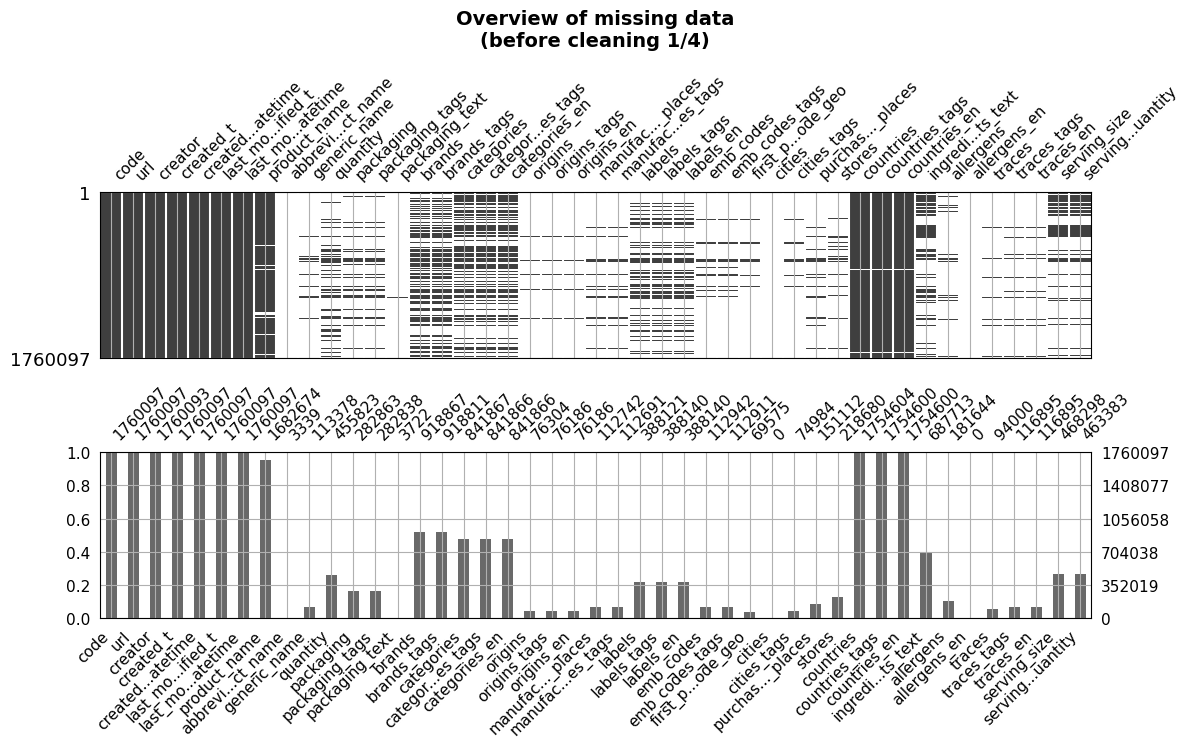

In [7]:
plot_export_missing(data, data.columns[0:45], 'C_0_3_missing_vals_1.png',
                    'Overview of missing data\n(before cleaning 1/4)',
                    shorten_label=True)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Cleaning dataset</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Deleting NaN columns and rows, and duplicated rows</h3>
</div>

In [ ]:
data = data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

In [ ]:
data = data.drop_duplicates()

In [ ]:
df_analysis(data, "data", "code")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.2. Fixing the columns types</h3>
</div>

<div class="alert alert-block alert-warning">
There are some columns with column type wrong. We can see this information based on:
<ul style="list-style-type: square;">
    <li>Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b></li>
    <li>At the momento to <b>import the *.csv</b></li>
    <li>As a result of the function <b>df_initial_analysis</b></li>
</ul>

Due to that, we are going to proceed to fix them. 
</div>
<div class="alert alert-block alert-info">
<b>Fixing column types float64</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following
<ul style="list-style-type: square;">
    <li>fields that end with <b>_100g</b> correspond to <b>the amount of a nutriment</b> (in g, or kJ for energy) for <b>100 g</b> or <b>100 ml</b> of product</li>
    <li>fields that end with <b>_serving</b> correspond to <b>the amount of a nutriment</b> (in g, or kJ for energy) for <b>1</b> serving of the product</li>
</ul>

Finally, we are going to make the <b>downcast</b> from <b>float64</b> to <b>float32</b> 
</div>

In [ ]:
for col in data.columns:
    if (col.endswith("_100g") or col.endswith("_serving")) and data[col].dtypes != "float64":
        print("Column to update the column type:", col, data[col].dtypes)
        data[col] = data[col].astype("float64")

In [ ]:
for col in data.columns:
    if data[col].dtypes == "float64":
        data[col] = data[col].astype("float32")

<div class="alert alert-block alert-info">
<b>Fixing column types datetime</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following:
<ul style="list-style-type: square;">
    <li>fields that end with <b>_t</b> are dates in <b>the UNIX timestamp format</b> (number of seconds since Jan 1st 1970)</b></li>
    <li>fields that end with <b>_datetime</b> are dates in <b>the iso8601 format: yyyy-mm-ddThh:mn:ssZ</b></li>
</ul>

In this case, both group of columns have the same amount of data. Due to that, we will only keep the columns ended by <b>_datetime</b>
</div>

In [ ]:
for col in data.columns:
    if col.endswith("_datetime") and data[col].dtypes != "datetime64":
        print("Column to update the column type:", col, data[col].dtypes)
        data[col] = data[col].astype("datetime64")

In [ ]:
for col in data.columns:
    if col.endswith("_t"):
        print("Column to delete:", col, data[col].dtypes)
        data = data.drop(col, axis=1)  

<div class="alert alert-block alert-info">
Checking the usage of memory
</div>

In [ ]:
data.info(memory_usage="deep")

<div class="alert alert-block alert-info">
If the number of unique values in a specific column is less than the half numbers of rows in the same column,<br>
we are going to change the type from <b>object</b> to <b>category</b> to improve the usage of memory
</div>

In [ ]:
for col in data.columns:
    if data[col].dtypes == "object":
        if len(data[col].unique()) / len(data[col]) < 0.5:
            data[col] = data[col].astype("category")
        else:
            data[col] = data[col].astype("object")

<div class="alert alert-block alert-info">
Checking the usage of memory
</div>

In [ ]:
data.info(memory_usage="deep")

In [ ]:
df_analysis(data, "data", "code")

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Filtering information</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Filtering information by country <b>France</b></h3>
</div>

<div class="alert alert-block alert-info">
<b>Countries where the product is sold</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following
<ul style="list-style-type: square;">
    <li> There are three fields about countries where the product is sold</li>
        <ul style="list-style-type: disc;">
            <li>countries</li>
            <li>countries_en</li>
            <li>countries_tags</li>
        </ul>
</ul>

After analyzing the columns, we have decided to used the columns called <b>countries</b>.<br>
We are going to filter considering only France and its overseas department
</div>

In [ ]:
FILTERING_BY_FRANCE = [
    "France", "fr", "Francia", "French", "Frankreich", "Nouvelle-Calédonie", "Martinique", "Guadeloupe", "Polynésie Française", "Mayotte"
]

<div class="alert alert-block alert-success">
At this point, we have reduced the amount of data in the dataset filtering by country France
</div>

In [ ]:
data = pd.DataFrame(data[data["countries"].str.contains("|".join(FILTERING_BY_FRANCE), case = False, na=False).any(level=0)])

In [ ]:
data.info(memory_usage="deep")

In [ ]:
df_analysis(data, "data", "code")

In [ ]:
data = data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

<div class="alert alert-block alert-info">
Exectuting the <b>describe()</b> function on the dataframe
</div>

In [ ]:
pd.set_option("display.max_columns", None) # show full of showing cols
data.describe()

In [ ]:
pd.reset_option("display.max_columns") # reset max of showing cols

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Nutri-Score fields</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.1. Idenfiying <b>Nutri-Score</b> fields</h3>
</div>

<div class="alert alert-block alert-info">
Based on <b>Santé publique France</b> we can get the fiedls to calculate the <b>Nutri-Score</b><br><br>
You can see the information in details in the link below<br>
<b>https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/articles/nutri-score</b><br><br>
    
<b>Nutri-Score fields</b>
<ul style="list-style-type: square;">
    <li>Energetic value</li>
    <li>Fat</li>
    <li>Saturated fat</li>
    <li>Sugar</li>
    <li>Protein</li>
    <li>Salt / Sodium</li>
    <li>Fibers</li>
    <li>Fruits, vegetables, legumes, nuts, rapeseed, walnut and olive oils</li>
</ul>
</div>

In [ ]:
pd.set_option("display.max_columns", None)
data.head(5)

In [ ]:
pd.reset_option("display.max_columns")

<div class="alert alert-block alert-info">
After analyzing the columns vs the <b>Nutri-Score</b>, we can identify the following fields
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
		<td align="center">Yes</td>
        <td align="left">
            energy-kj_100g<br>
            energy-kcal_100g<br>
            energy_100g</td>
        <td align="left">
            The fields energy-kj_100g and energy_100g seem to be the same value.<br>
            Consider the measure units to work with the values.
        </td>
 	</tr>
 	<tr>
		<td align="left">Fat</td>
		<td align="center">No</td>
        <td align="left">fat_100g</td>
        <td align="left"></td>
 	</tr>
 	<tr>
		<td align="left">Saturated fat</td>
		<td align="center">Yes</td>
        <td align="left">saturated-fat_100g</td>
        <td align="left"></td>
 	</tr>
 	<tr>
		<td align="left">Sugar</td>
		<td align="center">Yes</td>
        <td align="left">sugars_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">Protein</td>
		<td align="center">Yes</td>
        <td align="left">proteins_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">Salt / Sodium</td>
		<td align="center">Yes</td>
        <td align="left">
            salt_100g<br>
            sodium_100g</td>
        <td align="left">Consider the measure units to work with the values.</td>
 	</tr>
  	<tr>
		<td align="left">Fibers</td>
		<td align="center">Yes</td>
        <td align="left">fiber_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">
            Fruits, vegetables, legumes,<br>
            nuts, rapeseed, walnut<br> and olive oils
        </td>
		<td align="center">Yes</td>
        <td align="left">
            fruits-vegetables-nuts_100g<br>
            fruits-vegetables-nuts-estimate_100g
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
</table>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.2. Analyzing  the <b>Nutri-Score</b> fields</h3>
</div>

<div class="alert alert-block alert-info">
    Let's create a dataframe with interesting fields of <b>Nutri-Score</b> and the <b>application idea</b>
</div>

In [ ]:
BASIC_FIELDS_APP = [
    "code", "last_modified_datetime", "product_name", "categories", "categories_tags", "categories_fr", "image_url"
]

In [ ]:
NUTRI_SCORE_FIELDS = [
    "energy-kj_100g", "energy-kcal_100g", "energy_100g", "fat_100g", "saturated-fat_100g", 
    "sugars_100g", "proteins_100g", "salt_100g", "sodium_100g", "fiber_100g", 
    "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"
]

In [ ]:
df_nutri_score = data[BASIC_FIELDS_APP + NUTRI_SCORE_FIELDS].copy(deep=True)

In [ ]:
df_analysis(df_nutri_score, "df_nutri_score", "code", flag="complete")

<div class="alert alert-block alert-info">
    Processing the duplicates
</div>

In [ ]:
df_nutri_score.drop_duplicates(inplace=True)

In [ ]:
df_nutri_score.head(5)

In [ ]:
df_nutri_score.shape

<div class="alert alert-block alert-success">
    At this point, we have the <b>Nutri-Score</b> dataframe.
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Cleaning <b>Nutri-Score</b> dataframe</h2>
</div>

In [ ]:
df_nutri_score.loc[df_nutri_score["code"].str.startswith("200", na=False)].head(100)

In [ ]:
df_sam_temp = pd.DataFrame(df_sam["code"].str.startswith("2", na=False))

In [ ]:
df_sam_temp.head(5)

In [ ]:
df_sam = pd.DataFrame(df_nutri_score["code"])

In [ ]:
df_sam["code"].str.startswith("2", na=False).sum()

In [ ]:
df_sam.isnull().sum()

In [ ]:
797949

In [ ]:
df_nutri_score[df_nutri_score["code"].str.startswith(200)].count()

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.1. Processing the <b>non-uniques codes</b></h3>
</div>

<div class="alert alert-block alert-warning">
    Based on the function <b>df_analysis</b> result, we can see that there are some codes which are not unique so, it is necessary to work on them</br></br>
   
To do this, we are going to make the following steps:
<ul style="list-style-type: square;">
    <li>Filter the dataset by non-unique <b>code</b></li>
    <li>Select most recent value based on year for each code considering the multiples columns</li>
    <li>Merge the dataset with the filtered information</li>
</ul>
</div>

In [ ]:
df_temp = df_nutri_score[df_nutri_score.duplicated(subset=["code"], keep=False)].copy()
df_temp = df_temp.sort_values(["code", "last_modified_datetime"], ascending=True)

In [ ]:
df_temp.head(5)

In [ ]:
# df_temp["code"] = df_temp["code"].astype(str)

In [ ]:
df_temp = pd.DataFrame(df_temp).reset_index()

In [ ]:
del df_temp["index"]
df_temp.head(5)

In [ ]:
df_temp = df_temp.rename_axis(None, axis=1)

In [ ]:
df_temp.head(5)

<div class="alert alert-block alert-info">
    Select most recent value based on year for each code considering the multiples columns
</div>

In [ ]:
df_temp = df_temp.groupby("code", as_index=False).last()

In [ ]:
df_temp.head(6)

<div class="alert alert-block alert-info">
    Deleting the non-unique values from <b>Nutri-Score</b> dataset
</div>

In [ ]:
df_temp.shape

In [ ]:
df_nutri_score.shape

In [ ]:
df_nutri_score = df_nutri_score[~df_nutri_score["code"].isin(df_temp["code"])]

In [ ]:
df_nutri_score.shape

<div class="alert alert-block alert-info">
    Concatenating the datasets to have <b>only unique</b> values by <b>code</b>
</div>

In [ ]:
df_nutri_score = pd.concat([df_nutri_score, df_temp])

In [ ]:
df_nutri_score.shape

In [ ]:
df_analysis(df_nutri_score, "df_nutri_score", "code", flag="complete")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2. Analyzing the <b>missing values</b> in <b>Energy field</b></h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
		<td align="center">Yes</td>
        <td align="left">
            energy-kj_100g<br>
            energy-kcal_100g<br>
            energy_100g</td>
        <td align="left">
            The fields energy-kj_100g and energy_100g seem to be the same value.<br>
            Consider the measure units to work with the values.
        </td>
 	</tr>
</table>

In [ ]:
df_analysis(df_nutri_score[["code", "energy_100g", "energy-kcal_100g", "energy-kj_100g"]], "df_nutri_score", "code", flag="complete")

<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [ ]:
VALUES_TEMP = [
    "3017620422003", "3033710065967", "3229820100234"
]

In [ ]:
df_nutri_score[df_nutri_score["code"].isin(VALUES_TEMP)]

<div class="alert alert-block alert-info">
The <b>energy_100g</b> and <b>energy-kj_100g</b> fields are the same but it is necessary to compare in details these columns</br>
Let's compare the fields considering the <b>energy-kj_100g</b> as main field because it has <b>fewer data</b> than The <b>energy_100g</b> field
<ul style="list-style-type: square;">
    <li><b>energy_100g</b> has 623047 values</li>
    <li><b>energy-kj_100g</b> has 71900 values</li>
</ul>
</div>

In [ ]:
df_temp = df_nutri_score[df_nutri_score["energy-kj_100g"].notnull()]

In [ ]:
df_temp = pd.DataFrame(df_temp[["code", "energy_100g", "energy-kj_100g"]])

<div class="alert alert-block alert-info">
Now, let's compare <b>energy_100g</b> with <b>energy-kcal_100g</b> 
</div>

In [ ]:
df_temp["comparison_column"] = np.where(df_temp["energy_100g"] == df_temp["energy-kj_100g"], True, False)

In [ ]:
print("Amount of rows with differentes data between \"energy_100g\" and \"energy-kj_100g\" is:",
        df_temp[df_temp["comparison_column"] == False].shape[0]
)

<div class="alert alert-block alert-success">
At this point, we got that there are only 4 rows with different data between <b>energy_100g</b> and <b>energy-kj_100g</b> fields so,</br> we can proceed to delete the <b>energy-kj_100g</b> field because the error could be minimum
</div>

In [ ]:
del df_nutri_score["energy-kj_100g"]

In [ ]:
df_analysis(df_nutri_score[["code", "energy_100g", "energy-kcal_100g"]], "df_nutri_score", "code", flag="complete")

<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [ ]:
VALUES_TEMP = [
    "3017620422003", "3033710065967", "3229820100234"
]

In [ ]:
df_nutri_score[df_nutri_score["code"].isin(VALUES_TEMP)]

<div class="alert alert-block alert-info">
As you know, at this point we have deleted <b>energy-kj_100g</b> field beacuse it is the same as <b>energy_100g</b><br><br>

On the other hand, we know the following:
<ul style="list-style-type: square;">
    <li>1 kcal = 4,1868 kJ</li>
    <li>1 kJ = 0,2388 kcal</li>
</ul>

So, we can try to complete the <b>energy_100g</b> field with values of <b>energy-kcal_100g</b> field after the respective unit of measure conversion
    
First of all, let's check whether there is some <b>energy_100g</b> values that we can complete with <b>energy-kj_100g</b> values
</div>

In [ ]:
print("Amount of \"energy_100g\" to complete with \"energy-kcal_100g\" is:",
        df_nutri_score[(df_nutri_score["energy_100g"].isna()) & (df_nutri_score["energy-kcal_100g"].notnull())].shape[0]
)

<div class="alert alert-block alert-success">
    There is not some <b>energy_100g</b> values that we can complete with <b>energy-kcal_100g</b> values so,</br> we can proceed to delete the <b>energy-kcal_100g</b> field
</div>

In [ ]:
del df_nutri_score["energy-kcal_100g"]

In [ ]:
df_analysis(df_nutri_score, "df_nutri_score", "code", flag="complete")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2. Analyzing the <b>missing values</b> in <b>Salt / Sodium</b></h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">Salt / Sodium</td>
		<td align="center">Yes</td>
        <td align="left">
            salt_100g<br>
            sodium_100g</td>
        <td align="left">Consider the measure units to work with the values.</td>
 	</tr>
</table>

In [ ]:
df_analysis(df_nutri_score[["code", "salt_100g", "sodium_100g"]], "df_nutri_score", "code", flag="complete")

In [ ]:
print("Amount of \"salt_100g\" to complete with \"energy-sodium_100g\" is:",
        df_nutri_score[(df_nutri_score["salt_100g"].isna()) & (df_nutri_score["sodium_100g"].notnull())].shape[0]
)

<div class="alert alert-block alert-success">
    Based on <b>df_analysis</b>, we can see that  There is not some <b>salt_100g</b> and <b>sodium_100g</b> have the same amount of data so,<br>
    we can proceed to delete one of them. In this case, we are going to delete <b>sodium_100g</b>
</div>

In [ ]:
del df_nutri_score["sodium_100g"]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2. Analyzing the <b>missing values</b> in <b>Fruits, vegetables, legumes,nuts, rapeseed, walnut and olive oils</b></h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">
            Fruits, vegetables, legumes,<br>
            nuts, rapeseed, walnut<br> and olive oils
        </td>
		<td align="center">Yes</td>
        <td align="left">
            fruits-vegetables-nuts_100g<br>
            fruits-vegetables-nuts-estimate_100g
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
</table>

In [ ]:
VALUES_TEMP = [
    "code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"
]

In [ ]:
df_analysis(df_nutri_score[VALUES_TEMP], "df_nutri_score", "code", flag="complete")

In [ ]:
df_temp = df_nutri_score[["code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"]]

<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [ ]:
VALUES_TEMP = [
    "8076809513722", "8076809545396", "8076809513388"
]

In [ ]:
df_nutri_score[df_nutri_score["code"].isin(VALUES_TEMP)]

<div class="alert alert-block alert-info">
    Based on the function <b>df_analysis</b> we can see that there are almost 100% of missing-values for the three columns.<br><br>
    At the same time and based on <b>https://fr.openfoodfacts.org/</b> who says that the field <b>fruits-vegetables-nuts-estimate_100g</b> is a manual estimation<br> with the list of ingredients so, we can say that the most important field is <b>fruits-vegetables-nuts_100g</b>.<br><br>
    Due to that, we can try to complete the field <b>fruits-vegetables-nuts_100g</b> with values of <b>fruits-vegetables-nuts-estimate_100g</b>
</div>

In [ ]:
print("Amount of \"fruits-vegetables-nuts_100g\" to complete with \"fruits-vegetables-nuts-estimate_100g\" is:",
        df_nutri_score[(df_nutri_score["fruits-vegetables-nuts_100g"].isna()) & (df_nutri_score["fruits-vegetables-nuts-estimate_100g"].notnull())].shape[0]
)

<div class="alert alert-block alert-info">
    The column <b>fruits-vegetables-nuts-estimate_100g</b> has 10280 records  that can use to complete the information in the column <b>fruits-vegetables-nuts_100g</b>.<br>
    So, let's try to use them. 
</div>

In [ ]:
df_nutri_score["fruits-vegetables-nuts_100g"].fillna(df_nutri_score["fruits-vegetables-nuts-estimate_100g"], inplace=True)

In [ ]:
print("Amount of \"fruits-vegetables-nuts_100g\" to complete with \"fruits-vegetables-nuts-estimate_100g\" is:",
        df_nutri_score[(df_nutri_score["fruits-vegetables-nuts_100g"].isna()) & (df_nutri_score["fruits-vegetables-nuts-estimate_100g"].notnull())].shape[0]
)

In [ ]:
VALUES_TEMP = [
    "code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"
]

In [ ]:
df_analysis(df_nutri_score[VALUES_TEMP], "df_nutri_score", "code", flag="complete")

<div class="alert alert-block alert-success">
    At this point, we have completed the information with the data contains in both column.<br>
    Now, we can delete the columns <b>fruits-vegetables-nuts-estimate_100g</b>
</div>

In [ ]:
del df_nutri_score["fruits-vegetables-nuts-estimate_100g"]

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. Treating <b>Nutri-Score</b> missing-values</h2>
</div>

<div class="alert alert-block alert-info">
    After cleaning <b>df_nutri_score</b> we got the table below (dataframe) to work on it.<br>
    Now, it is time to <b>treat</b> with <b>missing values</b> in our dataset
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
		<td align="center">Yes</td>
        <td align="left">energy_100g</td>
 	</tr>
 	<tr>
		<td align="left">Fat</td>
		<td align="center">No</td>
        <td align="left">fat_100g</td>
 	</tr>
 	<tr>
		<td align="left">Saturated fat</td>
		<td align="center">Yes</td>
        <td align="left">saturated-fat_100g</td>
 	</tr>
 	<tr>
		<td align="left">Sugar</td>
		<td align="center">Yes</td>
        <td align="left">sugars_100g</td>
 	</tr>
  	<tr>
		<td align="left">Protein</td>
		<td align="center">Yes</td>
        <td align="left">proteins_100g</td>
 	</tr>
  	<tr>
		<td align="left">Salt</td>
		<td align="center">Yes</td>
        <td align="left">salt_100g</td>
 	</tr>
  	<tr>
		<td align="left">Fibers</td>
		<td align="center">Yes</td>
        <td align="left">fiber_100g</td>
 	</tr>
  	<tr>
		<td align="left">
            Fruits, vegetables, legumes,<br>
            nuts, rapeseed, walnut<br> and olive oils
        </td>
		<td align="center">Yes</td>
        <td align="left">fruits-vegetables-nuts_100g</td>
 	</tr>
</table>

In [ ]:
df_analysis(df_nutri_score, "df_nutri_score", "code", flag="complete")

<div class="alert alert-block alert-warning">
    Based on the function <b>df_analysis</b> we got the following facts:
    
    <ul style="list-style-type: square;">
        <li>there are almost <b>28%</b> of <b>missing values</b> in the <b>dataset</b></li>
        <li>Most of <b>columns</b> are above <b>20%</b> of <b>missing values</b></li>
        <li>there are <b>two columns</b> above <b>80%</b> of <b>missing values</b></li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. Imputation by the mean</h3>
</div>

<div class="alert alert-block alert-danger">
<b>Position Flag</b>
</div>